In [ ]:
!pip install --upgrade triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 12.6 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.5.0
    Uninstalling triton-3.5.0:
      Successfully uninstalled triton-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu128 requires triton==3.5.0; platform_system == "Linux", but you have triton 3.6.0 which is incompatible.


In [1]:
import time
import torch
import triton
import triton.language as tl
import math

In [2]:
print("Triton version:", triton.__version__)

Triton version: 3.6.0


In [3]:
def attention_naive(X: torch.Tensor, W_q, W_k, W_v,
                    b_q, b_k, b_v, device) -> torch.Tensor:
    """
        X :     NxD (N: number of tokens, D: Dimension of latent space tokenizer)
        W_*:    D_headxD (D_head: Model space dimension / num heads)
    """

    # check if X is NxD
    assert(X.dim()==2)

    Q = torch.matmul(X, W_q.transpose(0,1)) + b_q[None, :]
    K = torch.matmul(X, W_k.transpose(0,1)) + b_k[None, :]
    V = torch.matmul(X, W_v.transpose(0,1)) + b_v[None, :]
    D_V = torch.tensor(V.shape[1], device=device)

    KQ_normalised = torch.matmul(Q, K.transpose(0,1)) / torch.sqrt(D_V)
    KQ_softmax = torch.softmax(KQ_normalised, dim=1)

    attention = torch.matmul(KQ_softmax, V)

    return attention

# @torch.compile(fullgraph=True)
def multiheaded_attention_naive(X: torch.Tensor, W_qkv, W_out,
                    b_qkv, b_out, num_heads=1, device="cuda") -> torch.Tensor:
    """
    W_qkv: 3DxD
    W_out: DxD
    b_qkv: 3D
    b_out: D
    """
    # check if X is NxD
    assert(X.dim()==2)

    N, D = X.shape
    D_head = math.ceil(D / num_heads)
    attention = torch.empty((N, D), device=device, dtype=torch.float16)

    for head in range(num_heads):
        head_start = head*D_head
        head_end = min(D, (head+1)*D_head)
        attention[:,head_start:head_end] = attention_naive(
            X,
            W_qkv[0:D, :][head_start:head_end, :],
            W_qkv[D:2*D, :][head_start:head_end, :],
            W_qkv[2*D:3*D, :][head_start:head_end, :],
            b_qkv[0+head_start:0+head_end],
            b_qkv[D+head_start:D+head_end],
            b_qkv[2*D+head_start:2*D+head_end],
            device
        )

    attention = torch.matmul(attention, W_out.transpose(0,1)) + b_out[None, :]

    return attention

## FlashAttention 1

In [12]:
@triton.jit
def _attention(
        Q, K, V,
        O, l, m,
        BLOCK_R : tl.constexpr,
        BLOCK_C : tl.constexpr,
        BLOCK_D : tl.constexpr,
        N_q : tl.constexpr, N_v : tl.constexpr,
        D_head : tl.constexpr, B_c : tl.constexpr, B_r : tl.constexpr,
        T_r : tl.constexpr, T_c : tl.constexpr,
        ):

    head_idx = tl.program_id(0)
    # transpose everything when passing args, so that moving across is linear.
    Q_ptr = Q + (head_idx * N_q * D_head)
    K_ptr = K + (head_idx * N_v * D_head)
    V_ptr = V + (head_idx * N_v * D_head)
    O_ptr = O + (head_idx * N_q * D_head)
    l_ptr = l + (head_idx * N_q)
    m_ptr = m + (head_idx * N_q)

    # Get ptrs for loading K,V,Q,O into SRAM
    D_indices = tl.arange(0, BLOCK_D)[:, None]          # (D_head, 1)
    C_indices = tl.arange(0, BLOCK_C)[None, :]          # (1, B_c)
    R_indices = tl.arange(0, BLOCK_R)[None, :]          # (1, B_r)
    # Moving the start of each row by N_v steps
    # then get B_c size slices from each row
    K_row_start_ptrs = K_ptr + (D_indices * N_v)            # (D_head, 1)
    K_j_ptrs = K_row_start_ptrs + C_indices                 # (D_head, B_c)
    V_row_start_ptrs = V_ptr + (D_indices * N_v)            # (D_head, 1)
    V_j_ptrs = V_row_start_ptrs + C_indices                 # (D_head, B_c)
    mask_KV = (D_indices < D_head) & (C_indices < B_c)      # (BLOCK_D, BLOCK_C)

    # Same for Q and O
    Q_row_start_ptrs = Q_ptr + (D_indices * N_q)            # (D_head, 1)
    Q_i_ptrs = Q_row_start_ptrs + R_indices                 # (D_head, B_r)
    O_row_start_ptrs = O_ptr + (D_indices * N_q)            # (D_head, 1)
    O_i_ptrs = O_row_start_ptrs + R_indices                 # (D_head, B_r)
    mask_QO = (D_indices < D_head) & (R_indices < B_r)      # (BLOCK_D, BLOCK_R)

    # Get the pointers for l and m
    l_i_ptrs = l_ptr + R_indices                            # (BLOCK_R,)
    m_i_ptrs = m_ptr + R_indices                            # (BLOCK_R,)
    mask_lm = R_indices < B_r                               # (BLOCK_R,)

    for j in range(T_c):
        K_j = tl.load(K_j_ptrs, mask=mask_KV, other=0.0)    # (D_head, B_c)
        V_j = tl.load(V_j_ptrs, mask=mask_KV, other=0.0).to(tl.float32)    # (D_head, B_c)

        for i in range(T_r):
            Q_i = tl.load(Q_i_ptrs, mask=mask_QO, other=0.0)                    # (D_head, B_r)
            O_i = tl.load(O_i_ptrs, mask=mask_QO, other=0.0).to(tl.float32)     # (D_head, B_r)
            l_i = tl.load(l_i_ptrs, mask=mask_lm, other=0.0).to(tl.float32)
            m_i = tl.load(m_i_ptrs, mask=mask_lm, other=float('-inf')).to(tl.float32)

            # Compute S_ij = Q_i x K_j^T
            scale = 1.0 / tl.sqrt(tl.full([], D_head, dtype=tl.float32))  # scalar
            S_ij = tl.dot(K_j.T, Q_i).to(tl.float32) * scale               # (B_c, B_r)

            # get the rowmax for S_ij
            m_ij = tl.max(S_ij, axis=0)                     # (B_r,)

            # compute exponents for softmax after subtracting max
            # element for numerical stability
            P_ij = tl.exp(S_ij - m_ij)                      # (B_c, B_r)

            # Compute the row sums for softmax
            l_ij = tl.sum(P_ij, axis=0)                     # (B_r,)

            # Update the global max m_i till this point
            # tl.cat threw an error when given dim=0, weird but okay because it defaults to 0
            # m_i_new = tl.max(tl.cat(m_ij, m_i[None, :]), axis=0, keep_dims=True)     # (1, B_r)
            m_i_new = tl.maximum(m_ij, m_i)                 # (B_r,)
            alpha = tl.exp(m_i - m_i_new)                   # (B_r,)
            beta  = tl.exp(m_ij - m_i_new)                  # (B_r,)
            l_i_new = alpha * l_i + beta * l_ij               # (B_r,)

            # Update the output
            # Broadcasting works here as the last dim is matched (D_head, Br) and (Br)
            PV = tl.dot(V_j, P_ij)                          # (D_head, B_r)
            O_i = ((l_i * alpha) * O_i + beta * PV) / l_i_new       # (D_head, B_r)

            # Store the computed O_i, l_i and m_i values
            tl.store(O_i_ptrs, O_i, mask=mask_QO)
            tl.store(l_i_ptrs, l_i_new, mask=mask_lm)
            tl.store(m_i_ptrs, m_i_new, mask=mask_lm)

            Q_i_ptrs += B_r
            O_i_ptrs += B_r
            l_i_ptrs += B_r
            m_i_ptrs += B_r

        K_j_ptrs += B_c    # shift ptrs for next iter
        V_j_ptrs += B_c
        Q_i_ptrs -= N_q
        O_i_ptrs -= N_q
        l_i_ptrs -= N_q
        m_i_ptrs -= N_q


def multiheaded_attention_triton(
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        W_qkv, W_out,
        b_qkv, b_out,
        num_heads=1,
        device="cuda") -> torch.Tensor:

    N_q, D = query.shape
    N_v, _ = value.shape
    dtype = W_qkv.dtype

    M = 16*1024*4     # HARD CODED SRAM

    # Q = torch.matmul(query, W_qkv[0:D, :].transpose(0,1)) + b_qkv[0:D][None, :]
    # K = torch.matmul(query, W_qkv[D:2*D, :].transpose(0,1)) + b_qkv[D:2*D][None, :]
    # V = torch.matmul(query, W_qkv[2*D:3*D, :].transpose(0,1)) + b_qkv[2*D:3*D][None, :]

    # buffers
    # Q = torch.zeros((N_q, D), device=device, dtype=dtype)
    # K = torch.zeros((N_v, D), device=device, dtype=dtype)
    # V = torch.zeros((N_v, D), device=device, dtype=dtype)
    D_head = math.ceil(D / num_heads)

    # for head in range(num_heads):
    #     hs = head * D_head
    #     he = min(D, (head + 1) * D_head)

    #     Wq = W_qkv[0:D, :][hs:he, :]
    #     Wk = W_qkv[D:2*D, :][hs:he, :]
    #     Wv = W_qkv[2*D:3*D, :][hs:he, :]

    #     bq = b_qkv[hs:he]
    #     bk = b_qkv[D + hs:D + he]
    #     bv = b_qkv[2*D + hs:2*D + he]

    #     Q[:, hs:he] = (query @ Wq.T) + bq[None, :]
    #     K[:, hs:he] = (key   @ Wk.T) + bk[None, :]
    #     V[:, hs:he] = (value @ Wv.T) + bv[None, :]

    # --- QKV Projections (full) ---
    Q = torch.matmul(query, W_qkv[0:D, :].T) + b_qkv[0:D][None, :]       # (N_q, D)
    K = torch.matmul(key, W_qkv[D:2*D, :].T) + b_qkv[D:2*D][None, :]     # (N_v, D)
    V = torch.matmul(value, W_qkv[2*D:3*D, :].T) + b_qkv[2*D:3*D][None, :] # (N_v, D)

    # multiheads are cascaded column wise, by taking the transpose, we can access each head in continuous space
    Q = Q.T.contiguous()
    K = K.T.contiguous()
    V = V.T.contiguous()

    B_c = math.ceil(M / (4*D))
    B_r = min(math.ceil(M / (4*D)), D)

    O = torch.zeros((D, N_q), device=device, dtype=torch.float32)    # transposed to match Q,K,V

    l = torch.zeros((num_heads, N_q), device=device, dtype=torch.float32)
    m = torch.full((num_heads, N_q), float('-inf'), device=device, dtype=torch.float32)

    T_r = math.ceil(N_q / B_r)
    T_c = math.ceil(N_v / B_c)

    BLOCK_R = triton.next_power_of_2(B_r)
    BLOCK_C = triton.next_power_of_2(B_c)
    BLOCK_D = triton.next_power_of_2(D_head)

    num_warps = 8
    grid = (num_heads, )

    _attention[grid](
        Q, K, V,
        O, l, m,
        BLOCK_R, BLOCK_C, BLOCK_D,
        N_q, N_v,
        D_head, B_c, B_r,
        T_r, T_c,
        num_warps=num_warps
    )

    #print(O.dtype, W_out.dtype)

    O = O.to(torch.float16)
    attention = torch.matmul(O.T, W_out.transpose(0,1)) + b_out[None, :]

    return attention

## FlashAttention 1 - With tiling

In [ ]:
@triton.jit
def _attention(
        Q, K, V,
        O, l, m,
        stride_qh, stride_qn,
        stride_kh, stride_ktc, stride_kn,
        stride_vh, stride_vtc, stride_vn,
        stride_oh, stride_otc, stride_on,
        stride_lh, stride_ltc,
        stride_mh, stride_mtc,
        BLOCK_R : tl.constexpr,
        BLOCK_C : tl.constexpr,
        BLOCK_D : tl.constexpr,
        N_q : tl.constexpr, N_v : tl.constexpr,
        D_head : tl.constexpr, B_c : tl.constexpr, B_r : tl.constexpr,
        T_r : tl.constexpr, T_c : tl.constexpr,
        ):

    head_idx = tl.program_id(0)
    tc_idx = tl.program_id(1)
    Q_ptr = Q + head_idx*stride_qh
    K_ptr = K + head_idx*stride_kh + tc_idx*stride_ktc
    V_ptr = V + head_idx*stride_vh + tc_idx*stride_vtc
    O_ptr = O + head_idx*stride_oh + tc_idx*stride_otc
    l_ptr = l + head_idx*stride_lh + tc_idx*stride_ltc
    m_ptr = m + head_idx*stride_mh + tc_idx*stride_mtc
    # # transpose everything when passing args, so that moving across is linear.
    # Q_ptr = Q + (head_idx * N_q * D_head)
    # K_ptr = K + (head_idx * N_v * D_head)
    # V_ptr = V + (head_idx * N_v * D_head)
    # O_ptr = O + (head_idx * N_q * D_head)
    # l_ptr = l + (head_idx * N_q)
    # m_ptr = m + (head_idx * N_q)

    # Get ptrs for loading K,V,Q,O into SRAM
    D_indices = tl.arange(0, BLOCK_D)[:, None]          # (D_head, 1)
    C_indices = tl.arange(0, BLOCK_C)[None, :]          # (1, B_c)
    R_indices = tl.arange(0, BLOCK_R)[None, :]          # (1, B_r)
    # Moving the start of each row by N_v steps
    # then get B_c size slices from each row
    K_row_start_ptrs = K_ptr + (D_indices * N_v)            # (D_head, 1)
    K_j_ptrs = K_row_start_ptrs + C_indices                 # (D_head, B_c)
    V_row_start_ptrs = V_ptr + (D_indices * N_v)            # (D_head, 1)
    V_j_ptrs = V_row_start_ptrs + C_indices                 # (D_head, B_c)
    mask_KV = (D_indices < D_head) & (C_indices < B_c)      # (BLOCK_D, BLOCK_C)

    # Same for Q and O
    Q_row_start_ptrs = Q_ptr + (D_indices * N_q)            # (D_head, 1)
    Q_i_ptrs = Q_row_start_ptrs + R_indices                 # (D_head, B_r)
    O_row_start_ptrs = O_ptr + (D_indices * N_q)            # (D_head, 1)
    O_i_ptrs = O_row_start_ptrs + R_indices                 # (D_head, B_r)
    mask_QO = (D_indices < D_head) & (R_indices < B_r)      # (BLOCK_D, BLOCK_R)

    # Get the pointers for l and m
    l_i_ptrs = l_ptr + R_indices                            # (BLOCK_R,)
    m_i_ptrs = m_ptr + R_indices                            # (BLOCK_R,)
    mask_lm = R_indices < B_r                               # (BLOCK_R,)

    for j in range(T_c):
        K_j = tl.load(K_j_ptrs, mask=mask_KV, other=0.0)    # (D_head, B_c)
        V_j = tl.load(V_j_ptrs, mask=mask_KV, other=0.0).to(tl.float32)    # (D_head, B_c)

        for i in range(T_r):
            Q_i = tl.load(Q_i_ptrs, mask=mask_QO, other=0.0)                    # (D_head, B_r)
            O_i = tl.load(O_i_ptrs, mask=mask_QO, other=0.0).to(tl.float32)     # (D_head, B_r)
            l_i = tl.load(l_i_ptrs, mask=mask_lm, other=0.0).to(tl.float32)
            m_i = tl.load(m_i_ptrs, mask=mask_lm, other=float('-inf')).to(tl.float32)

            # Compute S_ij = Q_i x K_j^T
            scale = 1.0 / tl.sqrt(tl.full([], D_head, dtype=tl.float32))  # scalar
            S_ij = tl.dot(K_j.T, Q_i).to(tl.float32) * scale               # (B_c, B_r)

            # get the rowmax for S_ij
            m_ij = tl.max(S_ij, axis=0)                     # (B_r,)

            # compute exponents for softmax after subtracting max
            # element for numerical stability
            P_ij = tl.exp(S_ij - m_ij)                      # (B_c, B_r)

            # Compute the row sums for softmax
            l_ij = tl.sum(P_ij, axis=0)                     # (B_r,)

            # Update the global max m_i till this point
            # tl.cat threw an error when given dim=0, weird but okay because it defaults to 0
            # m_i_new = tl.max(tl.cat(m_ij, m_i[None, :]), axis=0, keep_dims=True)     # (1, B_r)
            m_i_new = tl.maximum(m_ij, m_i)                 # (B_r,)
            alpha = tl.exp(m_i - m_i_new)                   # (B_r,)
            beta  = tl.exp(m_ij - m_i_new)                  # (B_r,)
            l_i_new = alpha * l_i + beta * l_ij               # (B_r,)

            # Update the output
            # Broadcasting works here as the last dim is matched (D_head, Br) and (Br)
            PV = tl.dot(V_j, P_ij)                          # (D_head, B_r)
            O_i = ((l_i * alpha) * O_i + beta * PV) / l_i_new       # (D_head, B_r)

            # Store the computed O_i, l_i and m_i values
            tl.store(O_i_ptrs, O_i, mask=mask_QO)
            tl.store(l_i_ptrs, l_i_new, mask=mask_lm)
            tl.store(m_i_ptrs, m_i_new, mask=mask_lm)

            Q_i_ptrs += B_r
            O_i_ptrs += B_r
            l_i_ptrs += B_r
            m_i_ptrs += B_r

        K_j_ptrs += B_c    # shift ptrs for next iter
        V_j_ptrs += B_c
        Q_i_ptrs -= N_q
        O_i_ptrs -= N_q
        l_i_ptrs -= N_q
        m_i_ptrs -= N_q


def multiheaded_attention_triton(
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        W_qkv, W_out,
        b_qkv, b_out,
        num_heads=1,
        device="cuda") -> torch.Tensor:

    N_q, D = query.shape
    N_v, _ = value.shape
    dtype = W_qkv.dtype

    M = 16*1024     # HARD CODED SRAM

    # Q = torch.matmul(query, W_qkv[0:D, :].transpose(0,1)) + b_qkv[0:D][None, :]
    # K = torch.matmul(query, W_qkv[D:2*D, :].transpose(0,1)) + b_qkv[D:2*D][None, :]
    # V = torch.matmul(query, W_qkv[2*D:3*D, :].transpose(0,1)) + b_qkv[2*D:3*D][None, :]

    # buffers
    Q = torch.zeros((N_q, D), device=device, dtype=dtype)
    K = torch.zeros((N_v, D), device=device, dtype=dtype)
    V = torch.zeros((N_v, D), device=device, dtype=dtype)
    D_head = math.ceil(D / num_heads)

    for head in range(num_heads):
        hs = head * D_head
        he = min(D, (head + 1) * D_head)

        Wq = W_qkv[0:D, :][hs:he, :]
        Wk = W_qkv[D:2*D, :][hs:he, :]
        Wv = W_qkv[2*D:3*D, :][hs:he, :]

        bq = b_qkv[hs:he]
        bk = b_qkv[D + hs:D + he]
        bv = b_qkv[2*D + hs:2*D + he]

        Q[:, hs:he] = torch.matmul(query, Wq.T) + bq[None, :]
        K[:, hs:he] = torch.matmul(key, Wk.T) + bk[None, :]
        V[:, hs:he] = torch.matmul(value, Wv.T) + bv[None, :]

    # multiheads are cascaded column wise, by taking the transpose, we can access each head in continuous space
    # Q = Q.T.contiguous()
    # K = K.T.contiguous()
    # V = V.T.contiguous()

    B_c = math.ceil(M / (4*D))
    B_r = min(math.ceil(M / (4*D)), D)
    T_r = math.ceil(N_q / B_r)
    T_c = math.ceil(N_v / B_c)

    Q = Q.view(N, num_heads, D_head).permute(1, 0, 2)
    K = K.view(T_c, B_c, num_heads, D_head).permute(2, 0, 1, 3)
    V = V.view(T_c, B_c, num_heads, D_head).permute(2, 0, 1, 3)

    O = torch.zeros((num_heads, T_c, N_q, D_head), device=device, dtype=torch.float32)    # transposed to match Q,K,V

    l = torch.zeros((num_heads, T_c, N_q), device=device, dtype=torch.float32)
    m = torch.full((num_heads, T_c, N_q), float('-inf'), device=device, dtype=torch.float32)

    BLOCK_R = triton.next_power_of_2(B_r)
    BLOCK_C = triton.next_power_of_2(B_c)
    BLOCK_D = triton.next_power_of_2(D_head)

    num_warps = 8
    grid = (num_heads, T_c)

    _attention[grid](
        Q, K, V,
        O, l, m,
        Q.stride(0), Q.stride(1),
        K.stride(0), K.stride(1), K.stride(2),
        V.stride(0), V.stride(1), V.stride(2),
        O.stride(0), O.stride(1), O.stride(2),
        l.stride(0), l.stride(1),
        m.stride(0), m.stride(1),
        BLOCK_R, BLOCK_C, BLOCK_D,
        N_q, N_v,
        D_head, B_c, B_r,
        T_r, T_c,
        num_warps=num_warps
    )

    #print(O.dtype, W_out.dtype)

    O = O.to(torch.float16)
    attention = torch.matmul(O.T, W_out.transpose(0,1)) + b_out[None, :]

    return attention

## FlashAttention 2

In [11]:
@triton.jit
def _attention(
        Q, K, V,
        O, l, m,
        stride_qh, stride_qn,
        stride_kh, stride_kn,
        stride_vh, stride_vn,
        stride_oh, stride_on,
        stride_lh,
        stride_mh,
        BLOCK_R : tl.constexpr,
        BLOCK_C : tl.constexpr,
        BLOCK_D : tl.constexpr,
        N_q : tl.constexpr, N_v : tl.constexpr,
        D_head : tl.constexpr, B_c : tl.constexpr, B_r : tl.constexpr,
        T_r : tl.constexpr, T_c : tl.constexpr,
        sm_scale,
        ):
    # program_id(0) = head index (parallelized over heads)
    # program_id(1) = Q block (row block) index (parallelized over T_r)
    # BLOCK_R == B_r and BLOCK_C == B_c for this implementation
    head_idx = tl.program_id(0)
    tr_idx = tl.program_id(1)

    # --- Base pointers per head ---
    Q_ptr = Q + head_idx * stride_qh
    K_ptr = K + head_idx * stride_kh
    V_ptr = V + head_idx * stride_vh
    O_ptr = O + head_idx * stride_oh
    l_ptr = l + head_idx * stride_lh
    m_ptr = m + head_idx * stride_mh

    # --- Offsets for the current Q block (rows) ---
    # Q block: rows [tr_idx * B_r, tr_idx * B_r + B_r)
    offs_q = tr_idx * B_r + tl.arange(0, BLOCK_R)       # [BLOCK_R]
    offs_d = tl.arange(0, BLOCK_D)                      # [BLOCK_D]

    # Load Q block: [BLOCK_R, BLOCK_D]
    # Load only once as it is common for this kernel
    qo_mask = (offs_q[:, None] < N_q) & (offs_d[None, :] < D_head)
    q_ptrs_2d = Q_ptr + offs_q[:, None] * stride_qn + offs_d[None, :]
    q = tl.load(q_ptrs_2d, mask=qo_mask, other=0.0)

    # Initialize running statistics
    m_i = tl.full([BLOCK_R], value=float('-inf'), dtype=tl.float32)  # row-wise max
    l_i = tl.zeros([BLOCK_R], dtype=tl.float32)                      # row-wise sum of exp
    o_i = tl.zeros([BLOCK_R, BLOCK_D], dtype=tl.float32)             # accumulator for output

    # --- Inner loop over K/V blocks (columns) ---
    for tc in range(T_c):

        offs_kv = tc * B_c + tl.arange(0, BLOCK_C)      # [BLOCK_C]
        kv_mask = (offs_kv[:, None] < N_v) & (offs_d[None, :] < D_head)

        # Load K block: [BLOCK_C, BLOCK_D]
        k_ptrs_2d = K_ptr + offs_kv[:, None] * stride_kn + offs_d[None, :]
        k = tl.load(k_ptrs_2d, mask=kv_mask, other=0.0)

        # Load V block: [BLOCK_C, BLOCK_D]
        v_ptrs_2d = V_ptr + offs_kv[:, None] * stride_vn + offs_d[None, :]
        v = tl.load(v_ptrs_2d, mask=kv_mask, other=0.0)

        # S = Q @ K^T
        s = tl.dot(q, k.T) * sm_scale                   # [BLOCK_R, BLOCK_C]

        # Mask out-of-bounds KV positions
        # Only required when N_v % B_c != 0 (-inf to zero out the exponent)
        kv_mask = offs_kv[None, :] < N_v
        s = tl.where(kv_mask, s, float('-inf'))

        # Row-wise max of current block
        m_ij = tl.max(s, axis=1)                        # [BLOCK_R]

        # New running max
        m_new = tl.maximum(m_i, m_ij)                   # [BLOCK_R]

        # Correction factor for previous accumulator
        alpha = tl.exp(m_i - m_new)
        # Softmax numerator for current block
        p = tl.exp(s - m_new[:, None])                  # [BLOCK_R, BLOCK_C]

        # Update running sum
        l_i = l_i * alpha + tl.sum(p, axis=1)           # [BLOCK_R]

        # Rescale previous output accumulator (step 10)
        o_i = o_i * alpha[:, None]                      # [BLOCK_R, BLOCK_D]

        # Accumulate: O += P @ V (step 10)
        o_i += tl.dot(p.to(v.dtype), v)                 # [BLOCK_R, BLOCK_D]

        # Update running max
        m_i = m_new

    # --- Normalize output ---
    o_i = o_i / l_i[:, None]

    # --- Store outputs ---
    o_ptrs_2d = O_ptr + offs_q[:, None] * stride_on + offs_d[None, :]
    tl.store(o_ptrs_2d, o_i, mask=qo_mask)

    # Store l and m (per-row statistics, useful for backward pass)
    # q_mask_1d = offs_q < N_q
    # tl.store(l_ptr + offs_q, l_i, mask=q_mask_1d)
    # tl.store(m_ptr + offs_q, m_i, mask=q_mask_1d)


def multiheaded_attention_triton(
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        W_qkv, W_out,
        b_qkv, b_out,
        num_heads=1,
        device="cuda") -> torch.Tensor:

    N_q, D = query.shape
    N_v, _ = key.shape
    dtype = W_qkv.dtype
    D_head = D // num_heads

    # --- QKV Projections (full) ---
    Q = torch.matmul(query, W_qkv[0:D, :].T) + b_qkv[0:D][None, :]       # (N_q, D)
    K = torch.matmul(key, W_qkv[D:2*D, :].T) + b_qkv[D:2*D][None, :]     # (N_v, D)
    V = torch.matmul(value, W_qkv[2*D:3*D, :].T) + b_qkv[2*D:3*D][None, :] # (N_v, D)

    # --- Reshape to multi-head: (num_heads, seq_len, D_head) ---
    Q = Q.reshape(N_q, num_heads, D_head).permute(1, 0, 2).contiguous()  # (H, N_q, D_head)
    K = K.reshape(N_v, num_heads, D_head).permute(1, 0, 2).contiguous()  # (H, N_v, D_head)
    V = V.reshape(N_v, num_heads, D_head).permute(1, 0, 2).contiguous()  # (H, N_v, D_head)

    # --- Block sizes ---
    BLOCK_D = triton.next_power_of_2(D_head)
    B_c = min(triton.next_power_of_2(N_v), 64)
    B_r = min(triton.next_power_of_2(N_q), 64)
    BLOCK_C = B_c
    BLOCK_R = B_r

    T_c = triton.cdiv(N_v, B_c)  # number of KV blocks
    T_r = triton.cdiv(N_q, B_r)  # number of Q blocks

    # --- Allocate outputs ---
    O = torch.zeros_like(Q)                                               # (H, N_q, D_head)
    l = torch.zeros((num_heads, N_q), device=device, dtype=torch.float32)
    m = torch.full((num_heads, N_q), fill_value=float('-inf'), device=device, dtype=torch.float32)

    # --- Grid: parallelize over (heads, Q blocks) ---
    grid = (num_heads, T_r)
    if D_head <= 64:
        num_warps = 4
    else:
        num_warps = 8

    sm_scale = 1.0 / math.sqrt(D_head)

    _attention[grid](
        Q, K, V,
        O, l, m,
        # Q strides: (H, N_q, D_head)
        Q.stride(0), Q.stride(1),
        # K strides: (H, N_v, D_head)
        K.stride(0), K.stride(1),
        # V strides: (H, N_v, D_head)
        V.stride(0), V.stride(1),
        # O strides: (H, N_q, D_head)
        O.stride(0), O.stride(1),
        # l strides: (H, N_q)
        l.stride(0),
        # m strides: (H, N_q)
        m.stride(0),
        BLOCK_R=BLOCK_R,
        BLOCK_C=BLOCK_C,
        BLOCK_D=BLOCK_D,
        N_q=N_q, N_v=N_v,
        D_head=D_head, B_c=B_c, B_r=B_r,
        T_r=T_r, T_c=T_c,
        sm_scale=sm_scale,
        # num_warps=num_warps,
    )

    # --- Reshape output back: (H, N_q, D_head) -> (N_q, D) ---
    O = O.permute(1, 0, 2).contiguous().reshape(N_q, D)

    # --- Output projection ---
    out = torch.matmul(O, W_out.T) + b_out[None, :]

    return out

## Helpers and Wrappers

In [12]:
# -----------------------------
# Timing helpers (your style)
# -----------------------------
@torch.no_grad()
def time_ms0(fn, iters=100, warmup=25):
    for _ in range(warmup):
        fn()
    torch.cuda.synchronize()

    start = torch.cuda.Event(enable_timing=True)
    end   = torch.cuda.Event(enable_timing=True)
    start.record()
    for _ in range(iters):
        fn()
    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end) / iters

def mha_naive_wrapper(X, mha: torch.nn.MultiheadAttention):
    num_heads = mha.num_heads
    in_proj_w = mha.in_proj_weight
    in_proj_b = mha.in_proj_bias
    out_proj = mha.out_proj
    device = in_proj_w.device

    attention_naive_out = multiheaded_attention_naive(
        X,
        in_proj_w,
        out_proj.weight,
        in_proj_b,
        out_proj.bias,
        num_heads,
        device
    )

    return attention_naive_out

def mha_triton_wrapper(X, mha: torch.nn.MultiheadAttention):
    num_heads = mha.num_heads
    in_proj_w = mha.in_proj_weight
    in_proj_b = mha.in_proj_bias
    out_proj = mha.out_proj
    device = in_proj_w.device

    attention_triton_out = multiheaded_attention_triton(
        X, X, X,
        in_proj_w,
        out_proj.weight,
        in_proj_b,
        out_proj.bias,
        num_heads,
        device
    )

    return attention_triton_out

def mha_torch_wrapper(X, mha: torch.nn.MultiheadAttention):
    # For (N, D) input, PyTorch interprets as (L, E) when unbatched.
    # This returns (L, E). Use need_weights=False to time only output.
    out, _ = mha(X, X, X, need_weights=False)
    return out

def report(name, ms, N, D):
    toks_per_s = N / (ms / 1e3)
    print(f"{name:>14}: {ms:8.3f} ms | {toks_per_s:10.1f} tokens/s")


## Static Benchmark

In [13]:
# -----------------------------
# Run benchmark
# -----------------------------
torch.manual_seed(42)
device="cuda"
N, D, H = 8192, 512, 8

X = torch.randn((N, D), device=device, dtype=torch.float16)

mha = torch.nn.MultiheadAttention(embed_dim=D, num_heads=H, device=device, dtype=torch.float16)
mha.eval()

# correctness check first
with torch.no_grad():
    ref = mha_torch_wrapper(X, mha)
    out = mha_naive_wrapper(X, mha)
    out_triton = mha_triton_wrapper(X, mha)
    print("max abs err:", (out - ref).abs().max().item())
    print("mean abs err:", (out - ref).abs().mean().item())
    print("triton max abs err:", (out_triton - ref).abs().max().item())
    print("triton mean abs err:", (out_triton - ref).abs().mean().item())

# timing
torch_ms = time_ms0(lambda: mha_torch_wrapper(X, mha), iters=100, warmup=25)
naive_ms = time_ms0(lambda: mha_naive_wrapper(X, mha), iters=20, warmup=5)  # naive is O(N^2); use fewer iters
triton_ms = time_ms0(lambda: mha_triton_wrapper(X, mha), iters=100, warmup=25)

report("torch_mha", torch_ms, N, D)
report("naive_mha", naive_ms, N, D)
report("triton_mha", triton_ms, N, D)

max abs err: 3.0517578125e-05
mean abs err: 2.3245811462402344e-06
triton max abs err: 3.0517578125e-05
triton mean abs err: 2.1457672119140625e-06
     torch_mha:    1.168 ms |  7013667.8 tokens/s
     naive_mha:   10.300 ms |   795335.4 tokens/s
    triton_mha:    1.334 ms |  6140054.7 tokens/s


In [16]:
x = torch.full((5,), float('inf'), device=device)

In [14]:
x = torch.zeros((2,5,7))
x.shape, x.stride(0), x.stride(1), x.stride(2)

(torch.Size([2, 5, 7]), 35, 7, 1)

## Benchmarking

In [14]:
import math
import time
import torch
import matplotlib.pyplot as plt

# -----------------------------
# Helpers
# -----------------------------
def _dtype_nbytes(dtype: torch.dtype) -> int:
    # torch.finfo exists for float types, but simplest:
    if dtype == torch.float16: return 2
    if dtype == torch.bfloat16: return 2
    if dtype == torch.float32: return 4
    if dtype == torch.float64: return 8
    # fallback
    return torch.tensor([], dtype=dtype).element_size()

def _throughput_tokens_per_s(N: int, ms: float) -> float:
    # "Tokens" = sequence positions processed per forward call
    # tokens/s = N / (ms/1000)
    return (N * 1000.0) / ms if ms > 0 else float("inf")

def _throughput_bytes_per_s(N: int, D: int, dtype: torch.dtype, ms: float, rw_factor: float = 3.0) -> float:
    """
    Rough bandwidth estimate: reads X and writes O; rw_factor is a heuristic.
    For attention, real traffic is higher (QKV, weights, softmax, etc).
    Use as a consistent relative metric, not absolute truth.
    """
    nbytes = _dtype_nbytes(dtype)
    bytes_moved = rw_factor * (N * D * nbytes)
    return (bytes_moved * 1000.0) / ms if ms > 0 else float("inf")

def _set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

# -----------------------------
# Correctness check
# -----------------------------
@torch.no_grad()
def correctness_check(X, mha, atol=None, rtol=None, verbose=True):
    """
    Prints max/mean abs error vs torch reference for naive and triton.
    If atol/rtol provided, asserts allclose.
    """
    ref = mha_torch_wrapper(X, mha)
    out_naive = mha_naive_wrapper(X, mha)
    out_triton = mha_triton_wrapper(X, mha)

    max_abs_naive = (out_naive - ref).abs().max().item()
    mean_abs_naive = (out_naive - ref).abs().mean().item()
    max_abs_triton = (out_triton - ref).abs().max().item()
    mean_abs_triton = (out_triton - ref).abs().mean().item()

    if verbose:
        print("naive max abs err:", max_abs_naive)
        print("naive mean abs err:", mean_abs_naive)
        print("triton max abs err:", max_abs_triton)
        print("triton mean abs err:", mean_abs_triton)
        print("No. of zeros (triton):", (out_triton == 0).sum().item())

    if (atol is not None) or (rtol is not None):
        if atol is None: atol = 0.0
        if rtol is None: rtol = 0.0
        assert torch.allclose(out_naive, ref, atol=atol, rtol=rtol), "naive failed allclose"
        assert torch.allclose(out_triton, ref, atol=atol, rtol=rtol), "triton failed allclose"

    return {
        "naive_max_abs_err": max_abs_naive,
        "naive_mean_abs_err": mean_abs_naive,
        "triton_max_abs_err": max_abs_triton,
        "triton_mean_abs_err": mean_abs_triton,
    }

# -----------------------------
# Single-point benchmark (uses your time_ms0)
# -----------------------------
def bench_one(N: int, D: int, H: int,
              device="cuda", dtype=torch.float16,
              iters_torch=100, warmup_torch=25,
              iters_triton=100, warmup_triton=25,
              iters_naive=20, warmup_naive=5,
              do_correctness=False,
              seed=42):
    """
    Returns a dict with timings + throughput for torch/naive/triton at (N, D, H).
    Uses the same timing function time_ms0(...) you already have.
    """

    _set_seed(seed)
    X = torch.randn((N, D), device=device, dtype=dtype)
    mha = torch.nn.MultiheadAttention(embed_dim=D, num_heads=H, device=device, dtype=dtype)
    mha.eval()

    errs = None
    if do_correctness:
        errs = correctness_check(X, mha, verbose=True)

    # Ensure any lazy init is done before timing (optional)
    _sync()
    with torch.no_grad():
        _ = mha_torch_wrapper(X, mha)
        _ = mha_naive_wrapper(X, mha)
        _ = mha_triton_wrapper(X, mha)
    _sync()

    # timing: keep your function
    torch_ms  = time_ms0(lambda: mha_torch_wrapper(X, mha),  iters=iters_torch,  warmup=warmup_torch)
    naive_ms  = time_ms0(lambda: mha_naive_wrapper(X, mha),  iters=iters_naive,  warmup=warmup_naive)
    triton_ms = time_ms0(lambda: mha_triton_wrapper(X, mha), iters=iters_triton, warmup=warmup_triton)

    # optional report calls (your helper)
    try:
        report("torch_mha",  torch_ms,  N, D)
        report("naive_mha",  naive_ms,  N, D)
        report("triton_mha", triton_ms, N, D)
    except NameError:
        pass

    res = {
        "N": N, "D": D, "H": H, "dtype": str(dtype).replace("torch.", ""),
        "torch_ms": float(torch_ms),
        "naive_ms": float(naive_ms),
        "triton_ms": float(triton_ms),
        "torch_toks_s": _throughput_tokens_per_s(N, torch_ms),
        "naive_toks_s": _throughput_tokens_per_s(N, naive_ms),
        "triton_toks_s": _throughput_tokens_per_s(N, triton_ms),
        "torch_Bs": _throughput_bytes_per_s(N, D, dtype, torch_ms),
        "naive_Bs": _throughput_bytes_per_s(N, D, dtype, naive_ms),
        "triton_Bs": _throughput_bytes_per_s(N, D, dtype, triton_ms),
    }
    if errs is not None:
        res.update(errs)
    return res

# -----------------------------
# Sweep runner
# -----------------------------
def sweep_bench(
    Ns,
    D=128,
    H=2,
    device="cuda",
    dtype=torch.float16,
    do_correctness_first=True,
    seed=42,
    # per-impl timing params
    iters_torch=100, warmup_torch=25,
    iters_triton=100, warmup_triton=25,
    iters_naive=20, warmup_naive=5,
):
    """
    Sweeps over Ns. Returns list[dict] results.
    """
    results = []
    Ns = list(Ns)

    # One correctness check at the first N (optional)
    do_corr = bool(do_correctness_first)
    for i, N in enumerate(Ns):
        print(f"\n=== N={N}, D={D}, H={H}, dtype={dtype} ===")
        r = bench_one(
            N=N, D=D, H=H, device=device, dtype=dtype,
            iters_torch=iters_torch, warmup_torch=warmup_torch,
            iters_triton=iters_triton, warmup_triton=warmup_triton,
            iters_naive=iters_naive, warmup_naive=warmup_naive,
            do_correctness=do_corr,
            seed=seed,
        )
        do_corr = False  # only for first point
        results.append(r)
    return results

# -----------------------------
# Plotting
# -----------------------------
def plot_latency(results, x_key="N", logx=True, logy=False, title="MHA latency"):
    xs = [r[x_key] for r in results]
    torch_ms  = [r["torch_ms"] for r in results]
    naive_ms  = [r["naive_ms"] for r in results]
    triton_ms = [r["triton_ms"] for r in results]

    plt.figure()
    plt.plot(xs, torch_ms, marker="o", label="torch")
    plt.plot(xs, naive_ms, marker="o", label="naive")
    plt.plot(xs, triton_ms, marker="o", label="triton")
    plt.xlabel(x_key)
    plt.ylabel("time (ms)")
    plt.title(title)
    plt.grid(True, which="both")
    plt.legend()
    if logx: plt.xscale("log", base=2)
    if logy: plt.yscale("log")
    plt.show()

def plot_throughput(results, x_key="N", which="toks_s", logx=True, logy=False, title="MHA throughput"):
    """
    which: "toks_s" (tokens/s) or "Bs" (bytes/s)
    """
    xs = [r[x_key] for r in results]
    torch_tp  = [r[f"torch_{which}"] for r in results]
    naive_tp  = [r[f"naive_{which}"] for r in results]
    triton_tp = [r[f"triton_{which}"] for r in results]

    plt.figure()
    plt.plot(xs, torch_tp, marker="o", label="torch")
    plt.plot(xs, naive_tp, marker="o", label="naive")
    plt.plot(xs, triton_tp, marker="o", label="triton")
    plt.xlabel(x_key)
    plt.ylabel("tokens/s" if which == "toks_s" else "bytes/s (heuristic)")
    plt.title(title)
    plt.grid(True, which="both")
    plt.legend()
    if logx: plt.xscale("log", base=2)
    if logy: plt.yscale("log")
    plt.show()

# -----------------------------
# Pretty-print results
# -----------------------------
def print_table(results):
    # Minimal, dependency-free table print
    cols = ["N","D","H","torch_ms","naive_ms","triton_ms","torch_toks_s","naive_toks_s","triton_toks_s"]
    header = " | ".join([f"{c:>12}" for c in cols])
    print("\n" + header)
    print("-" * len(header))
    for r in results:
        row = []
        for c in cols:
            v = r[c]
            if isinstance(v, float):
                row.append(f"{v:12.4f}")
            else:
                row.append(f"{str(v):>12}")
        print(" | ".join(row))



=== N=256, D=2048, H=16, dtype=torch.float16 ===
naive max abs err: 0.0001220703125
naive mean abs err: 1.0371208190917969e-05
triton max abs err: 6.103515625e-05
triton mean abs err: 7.152557373046875e-06
No. of zeros (triton): 0
     torch_mha:    0.263 ms |   971741.7 tokens/s
     naive_mha:    6.571 ms |    38956.3 tokens/s
    triton_mha:    0.497 ms |   514827.0 tokens/s

=== N=512, D=2048, H=16, dtype=torch.float16 ===
     torch_mha:    0.271 ms |  1887504.8 tokens/s
     naive_mha:    6.121 ms |    83645.6 tokens/s
    triton_mha:    0.520 ms |   984232.6 tokens/s

=== N=1024, D=2048, H=16, dtype=torch.float16 ===
     torch_mha:    0.333 ms |  3072951.7 tokens/s
     naive_mha:    5.804 ms |   176418.2 tokens/s
    triton_mha:    0.562 ms |  1821062.4 tokens/s

=== N=1536, D=2048, H=16, dtype=torch.float16 ===
     torch_mha:    0.358 ms |  4293442.3 tokens/s
     naive_mha:    5.988 ms |   256508.9 tokens/s
    triton_mha:    0.603 ms |  2545824.9 tokens/s

=== N=2048, D=2

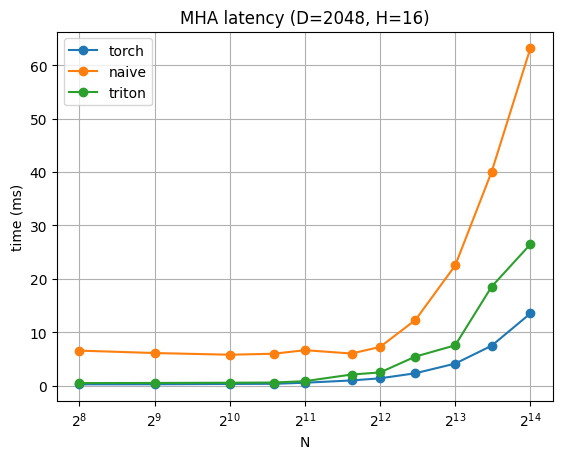

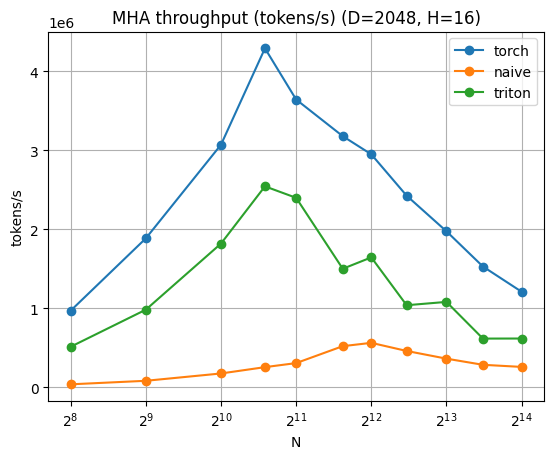

In [17]:
torch.manual_seed(42)
device = "cuda"
D, H = 2048, 16

Ns = [256, 512, 1024, 1536, 2048, 3148, 4096, 5674, 8192, 11468, 16384]  # pick what you want

results = sweep_bench(
    Ns=Ns, D=D, H=H, device=device, dtype=torch.float16,
    do_correctness_first=True,
    iters_torch=100, warmup_torch=25,
    iters_triton=100, warmup_triton=25,
    iters_naive=20, warmup_naive=5,   # keep naive lower like you did
)

print_table(results)

plot_latency(results, logx=True, logy=False, title=f"MHA latency (D={D}, H={H})")
plot_throughput(results, which="toks_s", logx=True, logy=False, title=f"MHA throughput (tokens/s) (D={D}, H={H})")
